# TimeQuant Quickstart

Demo of a streaming **Gaussian-Quantile tokenizer** for continuous time series.
- Univariate online tokenization with running mean/variance (Welford).
- Simple multivariate extension (per-dimension binning + k-means codebook).

> This notebook is standalone and dependency-light (NumPy & Matplotlib).

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt


# Utility: numerically stable running stats (Welford)
class RunningStats:
    def __init__(self, dim=None, eps=1e-8):
        self.n = 0
        self.mean = None if dim is None else np.zeros(dim, dtype=float)
        self.M2 = None if dim is None else np.zeros(dim, dtype=float)
        self.eps = eps

    def update(self, x):
        x = np.asarray(x)
        if self.mean is None:
            self.mean = np.zeros_like(x, dtype=float)
            self.M2 = np.zeros_like(x, dtype=float)
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2

    @property
    def var(self):
        if self.n < 2:
            return np.zeros_like(self.mean)
        return self.M2 / (self.n - 1)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)


# Fast approximation to the inverse CDF (PPF) of N(0,1) using Acklam's method
# Source: https://web.archive.org/web/20151030230722/http://home.online.no/~pjacklam/notes/invnorm/
def norm_ppf(p):
    if p <= 0.0 or p >= 1.0:
        if p == 0.0:
            return -np.inf
        if p == 1.0:
            return np.inf
        raise ValueError("p must be in (0,1)")
    # Coefficients in rational approximations
    a = [
        -3.969683028665376e01,
        2.209460984245205e02,
        -2.759285104469687e02,
        1.383577518672690e02,
        -3.066479806614716e01,
        2.506628277459239e00,
    ]
    b = [
        -5.447609879822406e01,
        1.615858368580409e02,
        -1.556989798598866e02,
        6.680131188771972e01,
        -1.328068155288572e01,
    ]
    c = [
        -7.784894002430293e-03,
        -3.223964580411365e-01,
        -2.400758277161838e00,
        -2.549732539343734e00,
        4.374664141464968e00,
        2.938163982698783e00,
    ]
    d = [
        7.784695709041462e-03,
        3.224671290700398e-01,
        2.445134137142996e00,
        3.754408661907416e00,
    ]
    # Define break-points
    plow = 0.02425
    phigh = 1 - plow
    if p < plow:
        q = math.sqrt(-2 * math.log(p))
        return (((((c[0] * q + c[1]) * q + c[2]) * q + c[3]) * q + c[4]) * q + c[5]) / (
            (((d[0] * q + d[1]) * q + d[2]) * q + d[3]) * q + 1
        )
    if phigh < p:
        q = math.sqrt(-2 * math.log(1 - p))
        return -(
            ((((c[0] * q + c[1]) * q + c[2]) * q + c[3]) * q + c[4]) * q + c[5]
        ) / ((((d[0] * q + d[1]) * q + d[2]) * q + d[3]) * q + 1)
    q = p - 0.5
    r = q * q
    return (
        (((((a[0] * r + a[1]) * r + a[2]) * r + a[3]) * r + a[4]) * r + a[5])
        * q
        / (((((b[0] * r + b[1]) * r + b[2]) * r + b[3]) * r + b[4]) * r + 1)
    )


class QuantileBinner:
    def __init__(self, V):
        self.V = int(V)
        qs = np.linspace(0, 1, self.V + 1)[1:-1]
        self.boundaries = np.array([norm_ppf(float(q)) for q in qs], dtype=float)

    def encode_scalar(self, z):
        # (-inf, b0], (b0, b1], ..., (b_{V-2}, inf)
        # use binary search via numpy
        return int(np.searchsorted(self.boundaries, z, side="right"))

    def decode_scalar(self, tok):
        if tok == 0:
            lo, hi = -np.inf, self.boundaries[0]
        elif tok == self.V - 1:
            lo, hi = self.boundaries[-1], np.inf
        else:
            lo, hi = self.boundaries[tok - 1], self.boundaries[tok]

        # midpoint via CDF mid-quantile
        def norm_cdf(x):  # numerical stable erf-based CDF
            return 0.5 * (1 + math.erf(x / math.sqrt(2)))

        q_lo = 0.0 if math.isinf(lo) and lo < 0 else norm_cdf(lo)
        q_hi = 1.0 if math.isinf(hi) and hi > 0 else norm_cdf(hi)
        q_mid = 0.5 * (q_lo + q_hi)
        return norm_ppf(q_mid)


class GQTokenizer:
    def __init__(self, V, eps=1e-8):
        """
        Gaussian-Quantile Tokenizer for univariate time series.

        Args:
            V: Vocabulary size
            eps: Numerical stability parameter
        """
        self.V = V
        self.eps = eps
        self.stats = RunningStats()
        self.binner = QuantileBinner(V)

    def update(self, x):
        """Update the tokenizer with new data point."""
        self.stats.update(x)

    def encode(self, x):
        """Encode data point to token."""
        z = (x - self.stats.mean) / self.stats.std
        return self.binner.encode_scalar(float(z))

    def decode(self, tok):
        """Decode token back to data point."""
        z = self.binner.decode_scalar(tok)
        return float(self.stats.mean + z * self.stats.std)

## 1) Univariate streaming demo

First 20 tokens: [ 8 12 13 14 14 12 13 13 12 13 12 14 14 14 14 14 15 14 14 13]


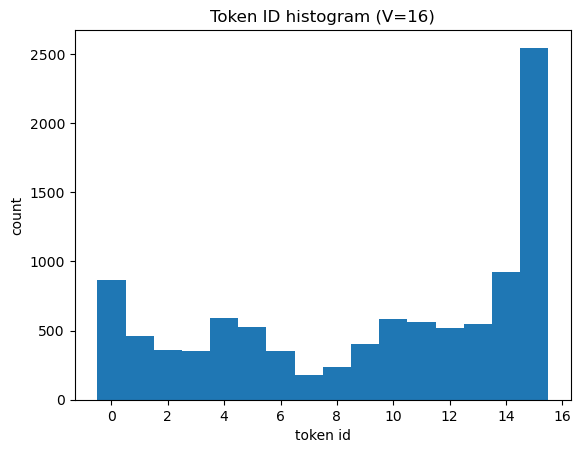

In [2]:
np.random.seed(0)
T = 10_000
# generate a nonstationary series: random walk + drift + noise
x = (
    np.cumsum(np.random.randn(T) * 0.5)
    + 0.01 * np.arange(T)
    + 0.5 * np.sin(np.arange(T) / 50)
)

tok = GQTokenizer(V=16)
tokens = np.empty(T, dtype=int)
for t in range(T):
    tok.update(x[t])
    tokens[t] = tok.encode(x[t])

print("First 20 tokens:", tokens[:20])
# Plot token histogram
plt.figure()
bins = np.arange(17) - 0.5
plt.hist(tokens, bins=bins)
plt.title("Token ID histogram (V=16)")
plt.xlabel("token id")
plt.ylabel("count")
plt.show()

## 2) Multivariate per-dimension binning + simple k-means codebook

Unique tokens used: 826/1024; perplexity≈608.39


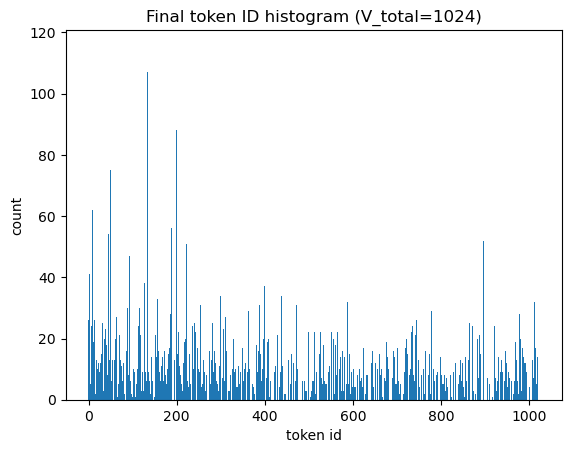

In [10]:
def kmeans_numpy(X, k, iters=50, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X), size=k, replace=False)
    C = X[idx].astype(float).copy()
    for _ in range(iters):
        # assign
        d2 = ((X[:, None, :] - C[None, :, :]) ** 2).sum(-1)
        y = d2.argmin(axis=1)
        # update
        for j in range(k):
            mask = y == j
            if mask.any():
                C[j] = X[mask].mean(axis=0)
    return C


D = 4
V_dim = 16  # 4-bit per dim
V_total = 1024  # final vocab via codebook

# make a 4D series with correlations
cov = np.array(
    [
        [1.0, 0.6, 0.0, 0.1],
        [0.6, 1.0, 0.2, 0.0],
        [0.0, 0.2, 1.0, 0.4],
        [0.1, 0.0, 0.4, 1.0],
    ]
)
L = np.linalg.cholesky(cov)
z = np.random.randn(T, D) @ L.T
X = (np.cumsum(z, axis=0) * 0.1) + 0.1 * np.sin(np.arange(T)[:, None] / 30)

# per-dim tokenizers
toks = [GQTokenizer(V=V_dim) for _ in range(D)]
codes = np.empty((T, D), dtype=int)
for t in range(T):
    for d in range(D):
        toks[d].update(X[t, d])
        codes[t, d] = toks[d].encode(X[t, d])

# fit a tiny codebook on a subset (streaming-friendly would use minibatches)
subset = codes#[1000:6000]
centroids = kmeans_numpy(subset.astype(float), k=V_total, iters=40, seed=0)

# map each code to nearest centroid => final token id
d2 = ((codes[:, None, :] - centroids[None, :, :]) ** 2).sum(-1)
final_tokens = d2.argmin(axis=1)

# utilization & perplexity
vals, counts = np.unique(final_tokens, return_counts=True)
p = counts / counts.sum()
H = -(p * np.log(p + 1e-12)).sum()
perplexity = float(np.exp(H))
print(f"Unique tokens used: {len(vals)}/{V_total}; perplexity≈{perplexity:.2f}")

plt.figure()
bins = np.arange(V_total + 1) - 0.5
plt.hist(final_tokens, bins=bins)
plt.title("Final token ID histogram (V_total=%d)" % V_total)
plt.xlabel("token id")
plt.ylabel("count")
plt.show()

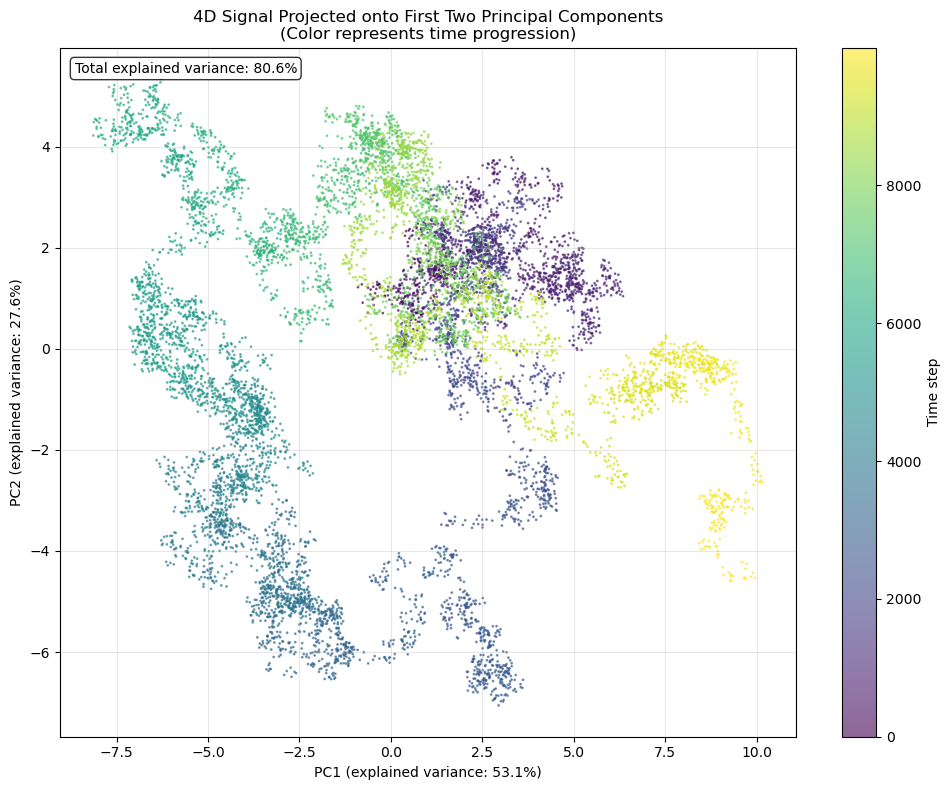

PCA explained variance ratios: [0.53059708 0.27568847]
Total explained variance by first 2 PCs: 80.6%


In [14]:
# Visualize 4D signal via PCA projection with time-based coloring
from sklearn.decomposition import PCA

# Compute PCA on the 4D signal
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create the visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=np.arange(T), cmap="viridis", alpha=0.6, s=1
)

plt.colorbar(scatter, label="Time step")
plt.xlabel(f"PC1 (explained variance: {pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 (explained variance: {pca.explained_variance_ratio_[1]:.1%})")
plt.title(
    "4D Signal Projected onto First Two Principal Components\n(Color represents time progression)"
)
plt.grid(True, alpha=0.3)

# Add some statistics
total_var = pca.explained_variance_ratio_.sum()
plt.text(
    0.02,
    0.98,
    f"Total explained variance: {total_var:.1%}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

print(f"PCA explained variance ratios: {pca.explained_variance_ratio_}")
print(f"Total explained variance by first 2 PCs: {total_var:.1%}")

Original data shape: (10000, 4)
Quantized data shape: (10000, 4)
Number of unique vectors in quantized data: 826
Expected unique vectors: 1024


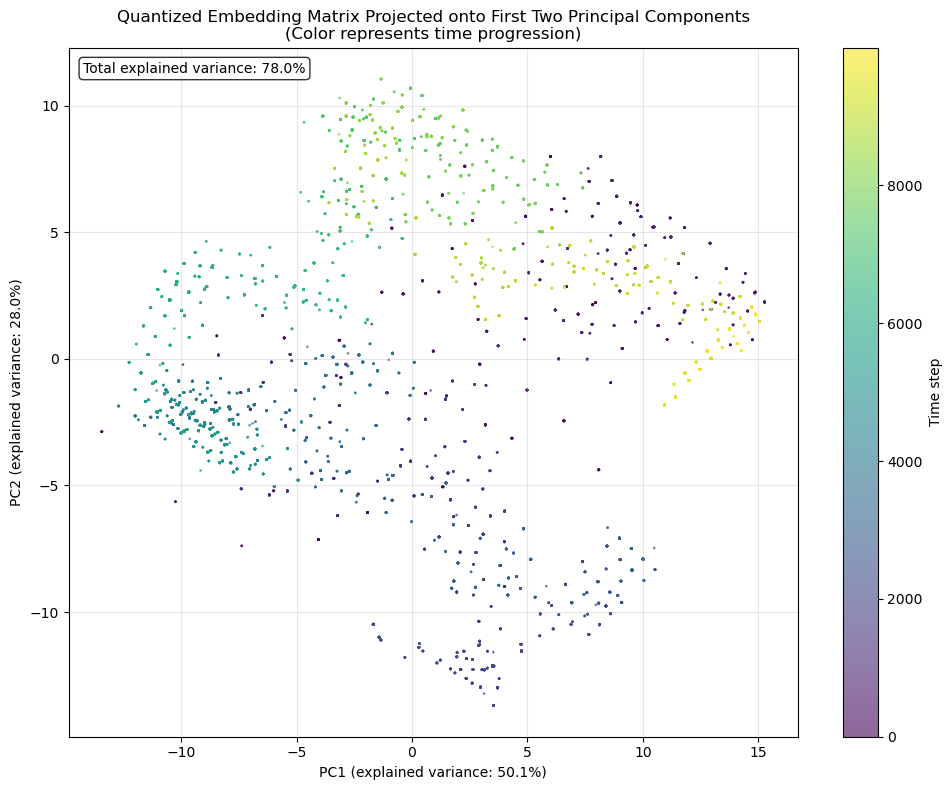

Quantized embedding PCA explained variance ratios: [0.50068124 0.27977832]
Total explained variance by first 2 PCs: 78.0%

Comparison of PCA explained variance:
Original signal: 80.6%
Quantized embeddings: 78.0%


In [15]:
# Create quantized embedding matrix: replace each timestep with its corresponding centroid
# This gives us a matrix with the same shape as X but with only V_total unique vectors

# Map each final token to its corresponding centroid
X_quantized = centroids[final_tokens]  # Shape: (T, D)

print(f"Original data shape: {X.shape}")
print(f"Quantized data shape: {X_quantized.shape}")

# Count unique vectors in quantized data (fix the unique counting)
unique_vectors = np.unique(X_quantized.reshape(X_quantized.shape[0], -1), axis=0)
print(f"Number of unique vectors in quantized data: {len(unique_vectors)}")
print(f"Expected unique vectors: {V_total}")

# Compute PCA on the quantized embedding matrix
pca_quantized = PCA(n_components=2)
X_quantized_pca = pca_quantized.fit_transform(X_quantized)

# Create the visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_quantized_pca[:, 0], X_quantized_pca[:, 1], c=np.arange(T), cmap="viridis", alpha=0.6, s=1
)

plt.colorbar(scatter, label="Time step")
plt.xlabel(f"PC1 (explained variance: {pca_quantized.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 (explained variance: {pca_quantized.explained_variance_ratio_[1]:.1%})")
plt.title(
    "Quantized Embedding Matrix Projected onto First Two Principal Components\n(Color represents time progression)"
)
plt.grid(True, alpha=0.3)

# Add some statistics
total_var_quantized = pca_quantized.explained_variance_ratio_.sum()
plt.text(
    0.02,
    0.98,
    f"Total explained variance: {total_var_quantized:.1%}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

print(f"Quantized embedding PCA explained variance ratios: {pca_quantized.explained_variance_ratio_}")
print(f"Total explained variance by first 2 PCs: {total_var_quantized:.1%}")

# Compare all three representations
print(f"\nComparison of PCA explained variance:")
print(f"Original signal: {total_var:.1%}")
print(f"Quantized embeddings: {total_var_quantized:.1%}")


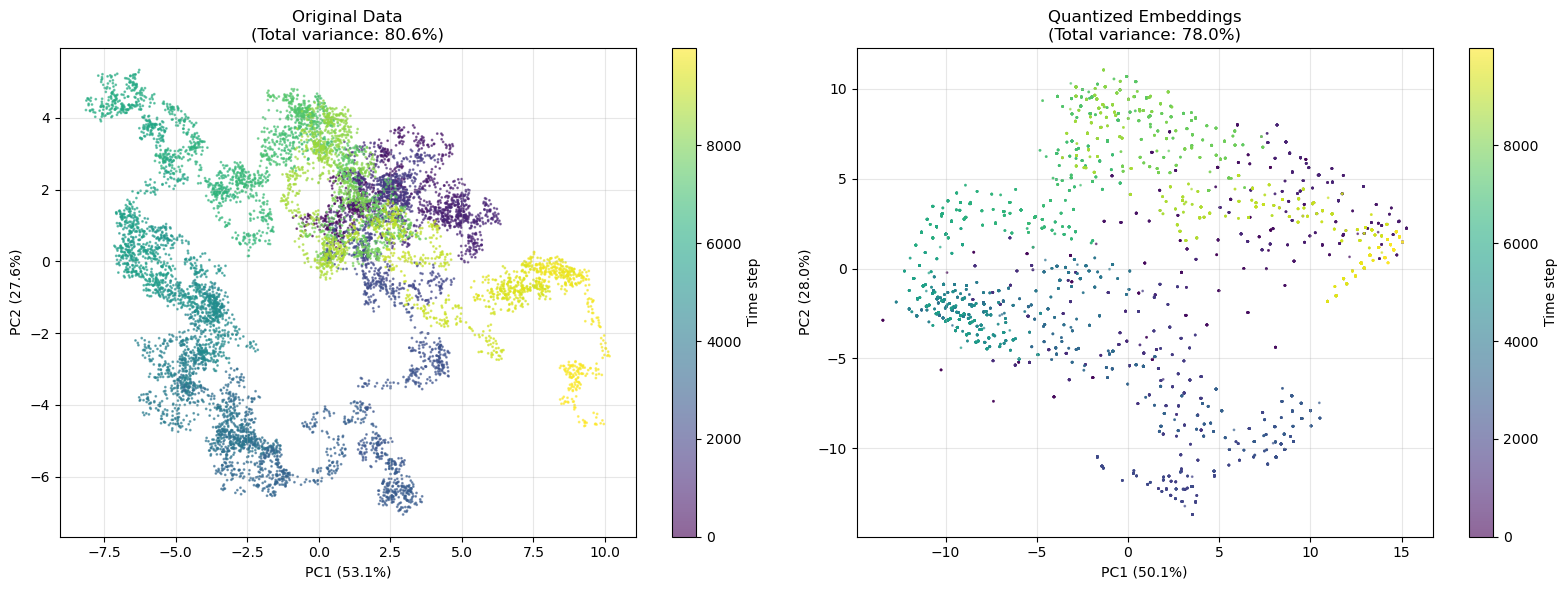

Mean Squared Error between original and quantized data: 67.717666
Root Mean Squared Error: 8.229074

Quantization Statistics:
Vocabulary size: 1024
Data dimensions: 4
Time steps: 10000
Compression ratio: 160000 bytes → 16384 bytes (10.24% of original size)


In [16]:
# Side-by-side comparison of original data vs quantized embeddings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original data PCA
scatter1 = ax1.scatter(
    X_pca[:, 0], X_pca[:, 1], c=np.arange(T), cmap="viridis", alpha=0.6, s=1
)
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
ax1.set_title(f"Original Data\n(Total variance: {total_var:.1%})")
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label="Time step")

# Quantized embeddings PCA
scatter2 = ax2.scatter(
    X_quantized_pca[:, 0], X_quantized_pca[:, 1], c=np.arange(T), cmap="viridis", alpha=0.6, s=1
)
ax2.set_xlabel(f"PC1 ({pca_quantized.explained_variance_ratio_[0]:.1%})")
ax2.set_ylabel(f"PC2 ({pca_quantized.explained_variance_ratio_[1]:.1%})")
ax2.set_title(f"Quantized Embeddings\n(Total variance: {total_var_quantized:.1%})")
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label="Time step")

plt.tight_layout()
plt.show()

# Calculate reconstruction error
mse = np.mean((X - X_quantized) ** 2)
print(f"Mean Squared Error between original and quantized data: {mse:.6f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.6f}")

# Show some statistics about the quantization
print(f"\nQuantization Statistics:")
print(f"Vocabulary size: {V_total}")
print(f"Data dimensions: {D}")
print(f"Time steps: {T}")
print(f"Compression ratio: {T * D * 4} bytes → {V_total * D * 4} bytes ({(V_total * D * 4) / (T * D * 4) * 100:.2f}% of original size)")


In [7]:
# np.unique(codes, axis=0), len(np.unique(codes, axis=0)) # V_dim^D - 1

# np.unique(codes_pca, axis=0).shape # V_dim^D - 1

# centroids # V_total (final vocab size)

# plt.plot(final_tokens)